# Evaluating the difficulty of a route

To provide the user with an objective measure of the route's difficulty beyond mere distance and climb metrics we need to create a difficulty score (or index). It will ideally take into account the following parameters:

1. Distance.
2. Elevation gain.
3. Stats relative to other routes.

In [65]:
import pandas as pd
import seaborn as sns
import math

In [49]:
#Importing our routes dataframe.

routes = pd.read_csv('routes_2207_618.csv')

In [31]:
#Checking for the longest routes.

longest = routes.sort_values('distance', ascending=False)
longest.head()

,ID,name,ccaa,province,start,midpoint,trailrank,distance,gradient,min_alt,max_alt,municipality,mountain_passes_ids,municipalities_ids
607,9531,La Almenara por Hornachuelos.,NaN,NaN,"[-5.106862,37.803821]","[-5.989482,37.41337]",19,226,2060,2,92,NaN,[1102],[2091]
259,2769,Ermida por Ourense y Puebla de Sanabria.,NaN,NaN,"[-6.403786,42.031926]","[-7.184281,42.3368]",32,224,4256,225,1313,NaN,[383],"[4956, 7763]"
195,7800,Carmona y Collado De Hoz por Cabezón de la Sal...,NaN,NaN,"[-4.23573,43.308033]","[-4.43152,43.106027]",48,222,3796,5,1248,NaN,"[288, 681, 838, 1101]","[5789, 5857, 5832]"
389,2450,Piedrasluengas y Carmona por Cabezón de la Sal...,NaN,NaN,"[-4.285052,43.376923]","[-4.573241,43.111127]",36,214,3523,0,1354,NaN,"[87, 288, 657, 838, 1101]","[5789, 5857, 5832, 5042]"
11,5257,Haza Del Lino por Motril y Dúrcal.,NaN,NaN,"[-3.596787,37.182303]","[-3.262158,36.758787]",66,214,3043,7,1275,NaN,[13],"[2800, 2747, 2806, 2818]"


In [30]:
#Checking for the ones with more elevation gain.

highest = routes.sort_values('gradient', ascending=False)
highest.head()

,ID,name,ccaa,province,start,midpoint,trailrank,distance,gradient,min_alt,max_alt,municipality,mountain_passes_ids,municipalities_ids
448,9347,Portela De Aldarís por Boiro y Padrón.,NaN,NaN,"[-8.652448,42.723446]","[-8.878824,42.697304]",23,87,5629,3,529,NaN,[764],"[2143, 2196]"
228,882,Ancares y Lumeras por Villafranca del Bierzo y...,NaN,NaN,"[-6.814618,42.603045]","[-6.856464,42.900584]",40,172,5307,481,1659,NaN,"[3, 335, 1109]","[3805, 4245]"
50,8392,Collada Llomena y Amieva por Cangas de Onís y ...,NaN,NaN,"[-5.14233,43.27333]","[-5.17584,43.19447]",53,97,5165,138,1063,NaN,"[68, 422]","[5006, 5009]"
416,8917,Muniketa y Natxitua por Durango y Zarautz.,NaN,NaN,"[-2.642798,43.177892]","[-2.418933,43.320043]",32,195,4774,0,413,NaN,"[353, 357, 699, 782, 1042, 1059]","[7525, 3227, 7544, 7515, 3165, 7571]"
340,9410,Calar Alto y Venta Luisa - Calar Alto por Tíjola.,NaN,NaN,"[-2.304858,37.36469]","[-2.693236,37.238361]",21,143,4619,469,2159,NaN,"[10, 29, 64, 77, 554]",[368]


## Removing outliers

In the previous section we noticed that a few routes have an extreme elevation gain (>5000m), thus making them unassailable from the fitness level of the average cyclist. In this section we will take a quick look at those routes and remove them if necessary. We will be using **Seaborn** for this purpose.

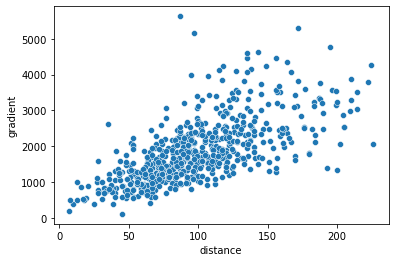

In [40]:
#Visualizing the distance/gradient distribution of all routes.

ax = sns.scatterplot(x="distance", y="gradient", data=routes)

It's easy to appreciate the roughly linear correlation between distance and elevation gain, which was quite expected. We can also see that the 3 routes with the most elevation gain are clearly outliers, including an extreme case. At this point we can't be really certain if those values are due to incredibly hard routes or faulty gps data, but our safest bet is removing them altogether.

Knowing that the outliers are the only routes with a gradient of over 5000, we can use a simple filter to drop them.

In [50]:
#Deleting all routes with a gradient over 5K.

routes = routes[routes['gradient'] <= 5000]

## Defining the criteria for the index

Now that our dataframe is free of outliers we can define which values will affect our index and by how much.

It must be taken into account that fatigue and tiredness are non-linear, meaning that a 200km route isn't just twice as hard as a 100km one, but quite significantly harder. Knowing this, our index score must be non-linear (at least partially). This will be done by assigning gradient a higher weight into the equation than distance.

Let's begin by taking a look at our dataframe values to get a feel of their distribution.

In [54]:
routes.describe()

,ID,ccaa,province,trailrank,distance,gradient,min_alt,max_alt,municipality
count,598.000000,0.0,0.0,598.000000,598.000000,598.000000,598.000000,598.000000,0.0
mean,4967.339465,NaN,NaN,43.304348,100.953177,1868.929766,280.249164,1028.526756,NaN
std,2963.295149,NaN,NaN,16.585528,39.519829,839.408467,309.387166,477.526137,NaN
min,7.000000,NaN,NaN,8.000000,31.000000,109.000000,0.000000,50.000000,NaN
25%,2456.000000,NaN,NaN,33.000000,72.000000,1262.500000,13.000000,632.000000,NaN
50%,4949.000000,NaN,NaN,41.000000,95.000000,1701.000000,167.500000,985.500000,NaN
75%,7744.500000,NaN,NaN,51.000000,122.000000,2327.750000,454.750000,1375.500000,NaN
max,10433.000000,NaN,NaN,96.000000,226.000000,4774.000000,1249.000000,2251.000000,NaN


We will be giving a score of **1** to the easiest possible route (100m / 30Km) and **9** to the hardest one (4000m / 230km), with a linear progression between the two. This means that 1/650ths of a point will be assigned for every meter of elevation past 100 and 1/75ths of a point for every Km past 30. This is in addition to the base score of **1**.

Routes with an elevation gain over 4000 will automatically be assigned a **10**.

# Creating our scoring function

We can easily assign a score to any route by packing the previously defined conditions into a simple function. Let's get to it.

In [110]:
#Defining our function:

def score(gradient, distance):
    if gradient > 4000:
        return 10
    else: #Checking for the first conditions.
        return math.ceil((gradient - 100)*(1.5/975) + (distance - 30)*(1/75) + 1) #We're rounding the score to the next integer.

In [111]:
for i in range(len(routes)):
    routes['difficulty_score'].iloc[i] = score(routes['gradient'].iloc[i], routes['distance'].iloc[i])

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [112]:
#Checking our scores.

routes.head(10)

,ID,name,ccaa,province,start,midpoint,trailrank,distance,gradient,min_alt,max_alt,municipality,mountain_passes_ids,municipalities_ids,difficulty_score
0,923,Angliru por Oviedo y Lena.,NaN,NaN,"[-6.101982,43.158859]","[-5.939921,43.235847]",67,124,3476,101,1566,NaN,[0],"[5039, 5027, 5020, 5067]",8
1,5611,Angliru y Gamoniteiro por Oviedo y Lena.,NaN,NaN,"[-5.8297,43.155729]","[-5.929957,43.288199]",51,118,4234,102,1700,NaN,"[0, 1, 84, 131]","[5039, 5027, 5067]",10
2,881,Ancares y Sierra De Morela por Cervantes y Ibias.,NaN,NaN,"[-7.157974,42.852246]","[-6.844199,42.889535]",55,130,2861,289,1651,NaN,"[3, 182, 1109]","[4245, 5022]",7
3,5618,Pajares-Cuitu Negru y La Cubilla por Lena.,NaN,NaN,"[-5.806177,43.128166]","[-5.829091,43.083221]",42,121,2917,344,1824,NaN,"[4, 51, 69, 438]",[5027],7
4,3467,Puerto Camacho y Haza Del Lino por Dúrcal y Ór...,NaN,NaN,"[-3.609443,37.156292]","[-3.275512,36.854694]",89,158,2450,242,1186,NaN,"[5, 13]","[2747, 2806, 2818]",7
5,5630,Morredero - Portillinos y Fonte Da Cova-Collad...,NaN,NaN,"[-6.598849,42.556634]","[-6.708998,42.29604]",61,157,3201,342,1960,NaN,"[6, 17, 32, 407]","[3723, 4910]",8
6,4740,Navacerrada-Bola Del Mundo y Morcuera por Rasc...,NaN,NaN,"[-3.770706,40.812061]","[-3.996795,40.785964]",46,100,2354,1035,2251,NaN,"[7, 148, 157, 229]",[4416],6
7,6550,Salto De La Cabra y Fuente Dé por Potes.,NaN,NaN,"[-4.609893,43.15849]","[-4.602693,43.170711]",39,99,2779,94,1101,NaN,"[9, 657, 838]",[5832],7
8,7252,Calar Alto y Velefique-Tetica De Bacares por G...,NaN,NaN,"[-2.391882,37.050099]","[-2.492193,37.26823]",80,122,3283,412,2164,NaN,"[10, 15, 29, 64, 77]",[325],8
9,691,Carrascoy por Murcia y Alhama de Murcia.,NaN,NaN,"[-1.153612,37.957681]","[-1.30439,37.831406]",15,73,1367,49,1064,NaN,[11],"[4613, 4591]",4


<AxesSubplot:xlabel='difficulty_score', ylabel='Count'>

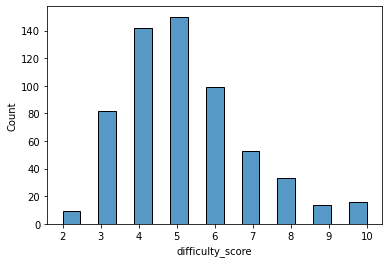

In [113]:
#Plotting the scores to visually inspect its distribution.

sns.histplot(data=routes, x="difficulty_score")

While this scoring system isn't perfect, it gives the user a good feeling of a route's difficulty in relation to other ones. 

In the future this score will be revised to take into account the non-linearity of fatigue.

In [116]:
#Finally saving our dataframe.

routes.to_csv('routes_2307_598.csv', index=False)

**<div align="right">Ironhack DA PT 2021</div>**
    
**<div align="right">Xavier Esteban</div>**